# Train Toy Model

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
import tensorflow as tf

RAW_DATA_PATH = 'input/data/'

MINITRAIN_PATH = 'input/data/train/'
MINIVAL_PATH = 'input/data/val/'
MINITEST_PATH = 'input/data/test/'

META_PATH = 'input/metadata/'
IMG_SIZE = 256
N_CHANNELS = 3

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

2023-09-30 11:11:33.306561: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-30 11:11:33.329700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 11:11:33.730863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-30 11:11:34.062395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 11:11:34.077805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 11:11:34.077961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
train_data = np.load(os.path.join(MINITRAIN_PATH, 'train.npz'))
X_train, y_train = train_data['X'], train_data['y']
output_shape = np.unique(y_train).shape[0]
print(X_train.shape, y_train.shape)

val_data = np.load(os.path.join(MINIVAL_PATH, 'val.npz'))
X_val, y_val = val_data['X'], val_data['y']
print(X_val.shape, y_val.shape)

test_data = np.load(os.path.join(MINITEST_PATH, 'test.npz'))
X_test, y_test = test_data['X'], test_data['y']
print(X_test.shape, y_test.shape)

(19600, 256, 256, 3) (19600,)
(1400, 256, 256, 3) (1400,)
(14957, 256, 256, 3) (14957,)


In [3]:
from keras import backend as K

# Generador de datos personalizado basado en Sequence
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data = self.data[start:end]
        batch_labels = self.labels[start:end]
        return batch_data, batch_labels

    def on_epoch_end(self):
        # Clear the Keras session to release GPU memory
        K.clear_session()



In [4]:
from tensorflow import keras

layers = [
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS)),
    keras.layers.Rescaling(1./255.),
    keras.layers.Conv2D(16,(3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (4, 4)),

    keras.layers.Dropout(0.8),
    keras.layers.Conv2D(128,(3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (4, 4)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(output_shape, activation='softmax')
]

model = keras.Sequential(layers)
'''
sparse_categorical_crossentropy para cuando las categorias vienen en una unica columna
categorical_crossentropy para cuando las categorias vienen en formato dummy
'''
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       18560     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                   

2023-09-30 11:11:54.589398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 11:11:54.589513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 11:11:54.589562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
train_generator = CustomDataGenerator(X_train, y_train, 8)
model.fit(train_generator, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100


2023-09-30 11:11:54.917159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-30 11:11:54.960746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-30 11:11:55.009411: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-09-30 11:11:55.009423: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-09-30 11:11:55.009453: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-09-30 11:11:55.

2450/2450 [==============================] - 16s 6ms/step - loss: 3.3138 - accuracy: 0.0542 - val_loss: 3.3029 - val_accuracy: 0.0807
Epoch 2/100
  33/2450 [..............................] - ETA: 11s - loss: 3.1914 - accuracy: 0.0795   

2023-09-30 11:12:10.913761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 14s 6ms/step - loss: 3.1862 - accuracy: 0.0832 - val_loss: 3.3017 - val_accuracy: 0.0893
Epoch 3/100
  29/2450 [..............................] - ETA: 13s - loss: 3.1331 - accuracy: 0.0819   

2023-09-30 11:12:24.494202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 17s 7ms/step - loss: 3.0762 - accuracy: 0.1161 - val_loss: 3.2307 - val_accuracy: 0.0579
Epoch 4/100
  28/2450 [..............................] - ETA: 14s - loss: 2.9208 - accuracy: 0.1205   

2023-09-30 11:12:41.507798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 2.8428 - accuracy: 0.1601 - val_loss: 3.0470 - val_accuracy: 0.0986
Epoch 5/100
  35/2450 [..............................] - ETA: 11s - loss: 2.8121 - accuracy: 0.1857   

2023-09-30 11:12:59.750989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 17s 7ms/step - loss: 2.5145 - accuracy: 0.2345 - val_loss: 2.8316 - val_accuracy: 0.1950
Epoch 6/100
  35/2450 [..............................] - ETA: 10s - loss: 2.3703 - accuracy: 0.2571

2023-09-30 11:13:16.748910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 15s 6ms/step - loss: 2.2387 - accuracy: 0.3224 - val_loss: 2.6871 - val_accuracy: 0.2564
Epoch 7/100
  33/2450 [..............................] - ETA: 11s - loss: 1.9964 - accuracy: 0.4394

2023-09-30 11:13:31.796805: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 14s 6ms/step - loss: 2.0724 - accuracy: 0.3680 - val_loss: 2.6240 - val_accuracy: 0.2993
Epoch 8/100
  28/2450 [..............................] - ETA: 14s - loss: 1.9691 - accuracy: 0.3973

2023-09-30 11:13:45.640706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 14s 6ms/step - loss: 1.9692 - accuracy: 0.3932 - val_loss: 2.5888 - val_accuracy: 0.3207
Epoch 9/100
  30/2450 [..............................] - ETA: 13s - loss: 1.8739 - accuracy: 0.4583   

2023-09-30 11:14:00.114855: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 15s 6ms/step - loss: 1.8945 - accuracy: 0.4195 - val_loss: 2.5464 - val_accuracy: 0.3057
Epoch 10/100
  30/2450 [..............................] - ETA: 12s - loss: 1.6518 - accuracy: 0.4875

2023-09-30 11:14:14.633423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 15s 6ms/step - loss: 1.8408 - accuracy: 0.4336 - val_loss: 2.5084 - val_accuracy: 0.3414
Epoch 11/100
  27/2450 [..............................] - ETA: 14s - loss: 1.6601 - accuracy: 0.4861

2023-09-30 11:14:29.220791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 14s 6ms/step - loss: 1.7673 - accuracy: 0.4501 - val_loss: 2.4547 - val_accuracy: 0.3250
Epoch 12/100
  28/2450 [..............................] - ETA: 14s - loss: 1.6749 - accuracy: 0.4688

2023-09-30 11:14:43.683270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 15s 6ms/step - loss: 1.7165 - accuracy: 0.4707 - val_loss: 2.3719 - val_accuracy: 0.3800
Epoch 13/100
  33/2450 [..............................] - ETA: 12s - loss: 1.5915 - accuracy: 0.5417

2023-09-30 11:14:58.568322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 14s 6ms/step - loss: 1.6734 - accuracy: 0.4835 - val_loss: 2.4081 - val_accuracy: 0.3729
Epoch 14/100
  32/2450 [..............................] - ETA: 12s - loss: 1.5123 - accuracy: 0.5391

2023-09-30 11:15:12.564505: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.6376 - accuracy: 0.4939 - val_loss: 2.3544 - val_accuracy: 0.4093
Epoch 15/100
  31/2450 [..............................] - ETA: 12s - loss: 1.7446 - accuracy: 0.4718

2023-09-30 11:15:25.945677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.5937 - accuracy: 0.5079 - val_loss: 2.3146 - val_accuracy: 0.3871
Epoch 16/100
  34/2450 [..............................] - ETA: 11s - loss: 1.7165 - accuracy: 0.4853

2023-09-30 11:15:38.712574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 14s 6ms/step - loss: 1.5643 - accuracy: 0.5190 - val_loss: 2.3087 - val_accuracy: 0.3814
Epoch 17/100
  35/2450 [..............................] - ETA: 11s - loss: 1.4718 - accuracy: 0.5214

2023-09-30 11:15:52.946482: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 16s 7ms/step - loss: 1.5407 - accuracy: 0.5240 - val_loss: 2.2546 - val_accuracy: 0.4086
Epoch 18/100
  31/2450 [..............................] - ETA: 12s - loss: 1.4788 - accuracy: 0.6250

2023-09-30 11:16:09.228985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 17s 7ms/step - loss: 1.4994 - accuracy: 0.5371 - val_loss: 2.2623 - val_accuracy: 0.3714
Epoch 19/100
  37/2450 [..............................] - ETA: 10s - loss: 1.5213 - accuracy: 0.5439

2023-09-30 11:16:26.738260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 17s 7ms/step - loss: 1.4847 - accuracy: 0.5420 - val_loss: 2.2617 - val_accuracy: 0.3814
Epoch 20/100
  26/2450 [..............................] - ETA: 15s - loss: 1.5326 - accuracy: 0.5000

2023-09-30 11:16:43.451363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 17s 7ms/step - loss: 1.4607 - accuracy: 0.5481 - val_loss: 2.2335 - val_accuracy: 0.4171
Epoch 21/100
  28/2450 [..............................] - ETA: 14s - loss: 1.4009 - accuracy: 0.5580

2023-09-30 11:17:00.981691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 8ms/step - loss: 1.4315 - accuracy: 0.5581 - val_loss: 2.1618 - val_accuracy: 0.4443
Epoch 22/100
  24/2450 [..............................] - ETA: 16s - loss: 1.5595 - accuracy: 0.5156

2023-09-30 11:17:19.478817: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 17s 7ms/step - loss: 1.4151 - accuracy: 0.5632 - val_loss: 2.1231 - val_accuracy: 0.4564
Epoch 23/100
  26/2450 [..............................] - ETA: 15s - loss: 1.2251 - accuracy: 0.6106

2023-09-30 11:17:36.881938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 1.3992 - accuracy: 0.5666 - val_loss: 2.1487 - val_accuracy: 0.4514
Epoch 24/100
  30/2450 [..............................] - ETA: 12s - loss: 1.3586 - accuracy: 0.6292

2023-09-30 11:17:54.967145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 17s 7ms/step - loss: 1.3764 - accuracy: 0.5744 - val_loss: 2.1349 - val_accuracy: 0.4400
Epoch 25/100
  25/2450 [..............................] - ETA: 16s - loss: 1.2031 - accuracy: 0.6350

2023-09-30 11:18:12.293102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 1.3632 - accuracy: 0.5772 - val_loss: 2.2079 - val_accuracy: 0.4364
Epoch 26/100
  25/2450 [..............................] - ETA: 16s - loss: 1.2994 - accuracy: 0.5400

2023-09-30 11:18:30.243731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 1.3446 - accuracy: 0.5846 - val_loss: 2.1413 - val_accuracy: 0.4464
Epoch 27/100
  29/2450 [..............................] - ETA: 14s - loss: 1.5184 - accuracy: 0.4914

2023-09-30 11:18:48.580414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 1.3254 - accuracy: 0.5899 - val_loss: 2.1735 - val_accuracy: 0.4357
Epoch 28/100
  34/2450 [..............................] - ETA: 11s - loss: 1.3482 - accuracy: 0.5919

2023-09-30 11:19:06.982159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 1.3078 - accuracy: 0.5941 - val_loss: 2.1625 - val_accuracy: 0.4243
Epoch 29/100
  18/2450 [..............................] - ETA: 16s - loss: 1.3741 - accuracy: 0.5417

2023-09-30 11:19:25.095824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 1.3004 - accuracy: 0.5966 - val_loss: 2.0809 - val_accuracy: 0.4650
Epoch 30/100
  31/2450 [..............................] - ETA: 12s - loss: 1.4036 - accuracy: 0.5524

2023-09-30 11:19:43.035461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 18s 7ms/step - loss: 1.2843 - accuracy: 0.6013 - val_loss: 2.0866 - val_accuracy: 0.4593
Epoch 31/100
  32/2450 [..............................] - ETA: 11s - loss: 1.3267 - accuracy: 0.6055

2023-09-30 11:20:00.571094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 16s 7ms/step - loss: 1.2758 - accuracy: 0.6039 - val_loss: 2.0568 - val_accuracy: 0.4714
Epoch 32/100
  34/2450 [..............................] - ETA: 11s - loss: 1.3025 - accuracy: 0.5956

2023-09-30 11:20:16.832752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 1.2501 - accuracy: 0.6074 - val_loss: 2.0325 - val_accuracy: 0.4971
Epoch 33/100
  32/2450 [..............................] - ETA: 12s - loss: 1.1879 - accuracy: 0.6406

2023-09-30 11:20:29.215589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.2405 - accuracy: 0.6106 - val_loss: 2.0468 - val_accuracy: 0.4964
Epoch 34/100
  32/2450 [..............................] - ETA: 12s - loss: 1.0907 - accuracy: 0.6641

2023-09-30 11:20:42.504901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.2276 - accuracy: 0.6187 - val_loss: 2.0494 - val_accuracy: 0.4764
Epoch 35/100
  32/2450 [..............................] - ETA: 12s - loss: 1.3439 - accuracy: 0.5586

2023-09-30 11:20:55.173850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 1.2180 - accuracy: 0.6152 - val_loss: 2.0260 - val_accuracy: 0.4764
Epoch 36/100
  32/2450 [..............................] - ETA: 12s - loss: 1.1691 - accuracy: 0.6406

2023-09-30 11:21:07.542784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1936 - accuracy: 0.6232 - val_loss: 2.0609 - val_accuracy: 0.4943
Epoch 37/100
  31/2450 [..............................] - ETA: 12s - loss: 1.2451 - accuracy: 0.7097

2023-09-30 11:21:20.168852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1918 - accuracy: 0.6257 - val_loss: 2.0111 - val_accuracy: 0.4900
Epoch 38/100
  34/2450 [..............................] - ETA: 11s - loss: 1.1912 - accuracy: 0.5882

2023-09-30 11:21:32.782504: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 1.1815 - accuracy: 0.6298 - val_loss: 1.9980 - val_accuracy: 0.4936
Epoch 39/100
  34/2450 [..............................] - ETA: 11s - loss: 1.2267 - accuracy: 0.6066

2023-09-30 11:21:45.215239: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1732 - accuracy: 0.6326 - val_loss: 1.9882 - val_accuracy: 0.4786
Epoch 40/100
  34/2450 [..............................] - ETA: 11s - loss: 1.2177 - accuracy: 0.5809

2023-09-30 11:21:58.057497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1571 - accuracy: 0.6368 - val_loss: 2.0273 - val_accuracy: 0.4957
Epoch 41/100
  33/2450 [..............................] - ETA: 12s - loss: 1.2426 - accuracy: 0.5947

2023-09-30 11:22:10.717033: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1525 - accuracy: 0.6406 - val_loss: 2.0067 - val_accuracy: 0.4850
Epoch 42/100
  34/2450 [..............................] - ETA: 11s - loss: 1.0498 - accuracy: 0.6581

2023-09-30 11:22:23.573211: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1353 - accuracy: 0.6440 - val_loss: 2.0717 - val_accuracy: 0.4729
Epoch 43/100
  33/2450 [..............................] - ETA: 11s - loss: 1.1176 - accuracy: 0.6439

2023-09-30 11:22:36.229938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1288 - accuracy: 0.6472 - val_loss: 2.0046 - val_accuracy: 0.4921
Epoch 44/100
  34/2450 [..............................] - ETA: 11s - loss: 1.1241 - accuracy: 0.6287

2023-09-30 11:22:48.969033: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1156 - accuracy: 0.6457 - val_loss: 1.9789 - val_accuracy: 0.5014
Epoch 45/100
  36/2450 [..............................] - ETA: 10s - loss: 1.3393 - accuracy: 0.5868

2023-09-30 11:23:01.606676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.1179 - accuracy: 0.6512 - val_loss: 2.0355 - val_accuracy: 0.5043
Epoch 46/100
  33/2450 [..............................] - ETA: 11s - loss: 1.0285 - accuracy: 0.6742

2023-09-30 11:23:14.284887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0993 - accuracy: 0.6573 - val_loss: 1.9733 - val_accuracy: 0.4929
Epoch 47/100
  33/2450 [..............................] - ETA: 12s - loss: 0.7849 - accuracy: 0.7765

2023-09-30 11:23:27.069175: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0940 - accuracy: 0.6555 - val_loss: 2.0542 - val_accuracy: 0.4800
Epoch 48/100
  35/2450 [..............................] - ETA: 11s - loss: 1.0790 - accuracy: 0.6714

2023-09-30 11:23:39.718433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0860 - accuracy: 0.6581 - val_loss: 2.0091 - val_accuracy: 0.4886
Epoch 49/100
  36/2450 [..............................] - ETA: 10s - loss: 1.0609 - accuracy: 0.6875

2023-09-30 11:23:52.504068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0731 - accuracy: 0.6649 - val_loss: 1.9576 - val_accuracy: 0.5086
Epoch 50/100
  34/2450 [..............................] - ETA: 11s - loss: 1.1291 - accuracy: 0.6397

2023-09-30 11:24:05.140272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0614 - accuracy: 0.6627 - val_loss: 1.9584 - val_accuracy: 0.4850
Epoch 51/100
  33/2450 [..............................] - ETA: 12s - loss: 1.1385 - accuracy: 0.6515

2023-09-30 11:24:17.969170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0543 - accuracy: 0.6662 - val_loss: 1.9611 - val_accuracy: 0.5050
Epoch 52/100
  33/2450 [..............................] - ETA: 11s - loss: 1.0436 - accuracy: 0.6742

2023-09-30 11:24:30.804664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0497 - accuracy: 0.6698 - val_loss: 2.0082 - val_accuracy: 0.4836
Epoch 53/100
  34/2450 [..............................] - ETA: 11s - loss: 0.9560 - accuracy: 0.6912

2023-09-30 11:24:43.380003: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 1.0388 - accuracy: 0.6701 - val_loss: 1.9848 - val_accuracy: 0.4971
Epoch 54/100
  32/2450 [..............................] - ETA: 12s - loss: 1.1816 - accuracy: 0.6445

2023-09-30 11:24:55.740599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0309 - accuracy: 0.6768 - val_loss: 1.9577 - val_accuracy: 0.5143
Epoch 55/100
  35/2450 [..............................] - ETA: 11s - loss: 1.0322 - accuracy: 0.6500

2023-09-30 11:25:08.400599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 1.0359 - accuracy: 0.6746 - val_loss: 2.0000 - val_accuracy: 0.5043
Epoch 56/100
  34/2450 [..............................] - ETA: 11s - loss: 1.0286 - accuracy: 0.6949

2023-09-30 11:25:20.724543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 1.0140 - accuracy: 0.6813 - val_loss: 1.9320 - val_accuracy: 0.4964
Epoch 57/100
  35/2450 [..............................] - ETA: 11s - loss: 0.8816 - accuracy: 0.7464

2023-09-30 11:25:33.344376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 1.0076 - accuracy: 0.6802 - val_loss: 1.9600 - val_accuracy: 0.5036
Epoch 58/100
  22/2450 [..............................] - ETA: 12s - loss: 1.1182 - accuracy: 0.6989

2023-09-30 11:25:45.853770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 1.0044 - accuracy: 0.6814 - val_loss: 1.9628 - val_accuracy: 0.5107
Epoch 59/100
  34/2450 [..............................] - ETA: 11s - loss: 1.0615 - accuracy: 0.6654

2023-09-30 11:25:58.322436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9882 - accuracy: 0.6902 - val_loss: 1.9601 - val_accuracy: 0.4900
Epoch 60/100
  34/2450 [..............................] - ETA: 11s - loss: 1.1255 - accuracy: 0.5846

2023-09-30 11:26:10.850983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9900 - accuracy: 0.6872 - val_loss: 1.9652 - val_accuracy: 0.4943
Epoch 61/100
  34/2450 [..............................] - ETA: 11s - loss: 1.0091 - accuracy: 0.7096

2023-09-30 11:26:23.438297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.9742 - accuracy: 0.6891 - val_loss: 1.9985 - val_accuracy: 0.5207
Epoch 62/100
  34/2450 [..............................] - ETA: 11s - loss: 0.9552 - accuracy: 0.7206

2023-09-30 11:26:35.774891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9735 - accuracy: 0.6912 - val_loss: 1.9739 - val_accuracy: 0.5179
Epoch 63/100
  36/2450 [..............................] - ETA: 10s - loss: 0.9122 - accuracy: 0.7326

2023-09-30 11:26:48.476538: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9776 - accuracy: 0.6888 - val_loss: 1.9662 - val_accuracy: 0.5029
Epoch 64/100
  33/2450 [..............................] - ETA: 11s - loss: 0.9554 - accuracy: 0.6970

2023-09-30 11:27:01.042683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9566 - accuracy: 0.6951 - val_loss: 1.9400 - val_accuracy: 0.4921
Epoch 65/100
  33/2450 [..............................] - ETA: 12s - loss: 0.9932 - accuracy: 0.6742

2023-09-30 11:27:13.944051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9537 - accuracy: 0.6971 - val_loss: 2.0160 - val_accuracy: 0.5143
Epoch 66/100
  34/2450 [..............................] - ETA: 11s - loss: 0.6415 - accuracy: 0.7904

2023-09-30 11:27:26.706569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9499 - accuracy: 0.6968 - val_loss: 1.9786 - val_accuracy: 0.5079
Epoch 67/100
  32/2450 [..............................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6914

2023-09-30 11:27:39.424053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9479 - accuracy: 0.6997 - val_loss: 1.9314 - val_accuracy: 0.5164
Epoch 68/100
  32/2450 [..............................] - ETA: 12s - loss: 1.1350 - accuracy: 0.6211

2023-09-30 11:27:52.107980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9403 - accuracy: 0.7006 - val_loss: 1.9275 - val_accuracy: 0.4993
Epoch 69/100
  33/2450 [..............................] - ETA: 11s - loss: 0.9091 - accuracy: 0.6932

2023-09-30 11:28:04.822343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9276 - accuracy: 0.7042 - val_loss: 1.9139 - val_accuracy: 0.5071
Epoch 70/100
  34/2450 [..............................] - ETA: 11s - loss: 0.8944 - accuracy: 0.7059

2023-09-30 11:28:17.563201: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9385 - accuracy: 0.7016 - val_loss: 1.9536 - val_accuracy: 0.5207
Epoch 71/100
  34/2450 [..............................] - ETA: 11s - loss: 0.9211 - accuracy: 0.7243

2023-09-30 11:28:30.247360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9183 - accuracy: 0.7083 - val_loss: 1.9173 - val_accuracy: 0.5121
Epoch 72/100
  34/2450 [..............................] - ETA: 11s - loss: 0.8178 - accuracy: 0.7537

2023-09-30 11:28:42.882344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.9120 - accuracy: 0.7089 - val_loss: 1.9144 - val_accuracy: 0.4986
Epoch 73/100
  34/2450 [..............................] - ETA: 11s - loss: 0.9039 - accuracy: 0.7463

2023-09-30 11:28:55.350487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9083 - accuracy: 0.7120 - val_loss: 1.9733 - val_accuracy: 0.5086
Epoch 74/100
  33/2450 [..............................] - ETA: 11s - loss: 0.8729 - accuracy: 0.7159

2023-09-30 11:29:07.890434: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.9031 - accuracy: 0.7138 - val_loss: 1.9033 - val_accuracy: 0.5129
Epoch 75/100
  34/2450 [..............................] - ETA: 11s - loss: 0.8043 - accuracy: 0.7610

2023-09-30 11:29:20.522105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8898 - accuracy: 0.7189 - val_loss: 1.9039 - val_accuracy: 0.5164
Epoch 76/100
  33/2450 [..............................] - ETA: 11s - loss: 0.9050 - accuracy: 0.6894

2023-09-30 11:29:33.176925: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8833 - accuracy: 0.7154 - val_loss: 1.9145 - val_accuracy: 0.5129
Epoch 77/100
  33/2450 [..............................] - ETA: 11s - loss: 0.7839 - accuracy: 0.7576

2023-09-30 11:29:46.010890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8834 - accuracy: 0.7165 - val_loss: 1.9791 - val_accuracy: 0.4821
Epoch 78/100
  35/2450 [..............................] - ETA: 11s - loss: 0.9272 - accuracy: 0.7179

2023-09-30 11:29:58.807647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8758 - accuracy: 0.7201 - val_loss: 1.9219 - val_accuracy: 0.4864
Epoch 79/100
  34/2450 [..............................] - ETA: 11s - loss: 0.8834 - accuracy: 0.7279

2023-09-30 11:30:11.532213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8772 - accuracy: 0.7215 - val_loss: 1.9346 - val_accuracy: 0.4936
Epoch 80/100
  32/2450 [..............................] - ETA: 12s - loss: 1.1036 - accuracy: 0.6367

2023-09-30 11:30:24.280446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8696 - accuracy: 0.7240 - val_loss: 1.9084 - val_accuracy: 0.5286
Epoch 81/100
  32/2450 [..............................] - ETA: 11s - loss: 0.7893 - accuracy: 0.7539

2023-09-30 11:30:37.026658: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8656 - accuracy: 0.7231 - val_loss: 1.9045 - val_accuracy: 0.5114
Epoch 82/100
  31/2450 [..............................] - ETA: 12s - loss: 0.9658 - accuracy: 0.6613

2023-09-30 11:30:49.941431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8523 - accuracy: 0.7265 - val_loss: 1.8958 - val_accuracy: 0.5029
Epoch 83/100
  35/2450 [..............................] - ETA: 11s - loss: 0.7699 - accuracy: 0.7321

2023-09-30 11:31:02.553741: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8459 - accuracy: 0.7273 - val_loss: 1.9014 - val_accuracy: 0.5014
Epoch 84/100
  32/2450 [..............................] - ETA: 12s - loss: 0.8101 - accuracy: 0.7148

2023-09-30 11:31:15.217104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8447 - accuracy: 0.7296 - val_loss: 1.9173 - val_accuracy: 0.5029
Epoch 85/100
  33/2450 [..............................] - ETA: 11s - loss: 0.9503 - accuracy: 0.6894

2023-09-30 11:31:27.844680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.8431 - accuracy: 0.7240 - val_loss: 1.9444 - val_accuracy: 0.4979
Epoch 86/100
  33/2450 [..............................] - ETA: 11s - loss: 0.7796 - accuracy: 0.7462

2023-09-30 11:31:40.356568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.8415 - accuracy: 0.7294 - val_loss: 1.9535 - val_accuracy: 0.5086
Epoch 87/100
  35/2450 [..............................] - ETA: 11s - loss: 0.5495 - accuracy: 0.8429

2023-09-30 11:31:52.755730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8432 - accuracy: 0.7278 - val_loss: 1.9223 - val_accuracy: 0.5143
Epoch 88/100
  34/2450 [..............................] - ETA: 11s - loss: 0.8586 - accuracy: 0.7206

2023-09-30 11:32:05.422709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8311 - accuracy: 0.7321 - val_loss: 1.9560 - val_accuracy: 0.5193
Epoch 89/100
  32/2450 [..............................] - ETA: 12s - loss: 0.7236 - accuracy: 0.7812

2023-09-30 11:32:18.106430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.8237 - accuracy: 0.7347 - val_loss: 1.9474 - val_accuracy: 0.4979
Epoch 90/100
  34/2450 [..............................] - ETA: 11s - loss: 0.7887 - accuracy: 0.7537

2023-09-30 11:32:30.527563: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8208 - accuracy: 0.7357 - val_loss: 1.9643 - val_accuracy: 0.5179
Epoch 91/100
  31/2450 [..............................] - ETA: 12s - loss: 0.8452 - accuracy: 0.7298

2023-09-30 11:32:43.296521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8245 - accuracy: 0.7329 - val_loss: 1.9284 - val_accuracy: 0.4850
Epoch 92/100
  34/2450 [..............................] - ETA: 11s - loss: 0.9272 - accuracy: 0.7279

2023-09-30 11:32:55.912283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.7996 - accuracy: 0.7436 - val_loss: 1.9225 - val_accuracy: 0.4757
Epoch 93/100
  34/2450 [..............................] - ETA: 11s - loss: 0.6316 - accuracy: 0.7684

2023-09-30 11:33:08.382301: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.7963 - accuracy: 0.7435 - val_loss: 1.9584 - val_accuracy: 0.5150
Epoch 94/100
  34/2450 [..............................] - ETA: 11s - loss: 0.7038 - accuracy: 0.7868

2023-09-30 11:33:20.704034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.8088 - accuracy: 0.7378 - val_loss: 1.9139 - val_accuracy: 0.5136
Epoch 95/100
  34/2450 [..............................] - ETA: 11s - loss: 0.7826 - accuracy: 0.7537

2023-09-30 11:33:33.415296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.7925 - accuracy: 0.7420 - val_loss: 1.9064 - val_accuracy: 0.5171
Epoch 96/100
  34/2450 [..............................] - ETA: 11s - loss: 0.7097 - accuracy: 0.7757

2023-09-30 11:33:46.128014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.8021 - accuracy: 0.7452 - val_loss: 1.9440 - val_accuracy: 0.5057
Epoch 97/100
  32/2450 [..............................] - ETA: 12s - loss: 0.7975 - accuracy: 0.7383

2023-09-30 11:33:58.599191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.7984 - accuracy: 0.7410 - val_loss: 1.9429 - val_accuracy: 0.5100
Epoch 98/100
  31/2450 [..............................] - ETA: 12s - loss: 0.7218 - accuracy: 0.7661

2023-09-30 11:34:11.037443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.7846 - accuracy: 0.7496 - val_loss: 1.9475 - val_accuracy: 0.4979
Epoch 99/100
  33/2450 [..............................] - ETA: 12s - loss: 0.8935 - accuracy: 0.7273

2023-09-30 11:34:23.586564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 13s 5ms/step - loss: 0.7825 - accuracy: 0.7444 - val_loss: 1.9439 - val_accuracy: 0.5057
Epoch 100/100
  33/2450 [..............................] - ETA: 11s - loss: 0.8249 - accuracy: 0.7538

2023-09-30 11:34:36.246086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2450/2450 [==============================] - 12s 5ms/step - loss: 0.7759 - accuracy: 0.7488 - val_loss: 1.9641 - val_accuracy: 0.4936


<Axes: >

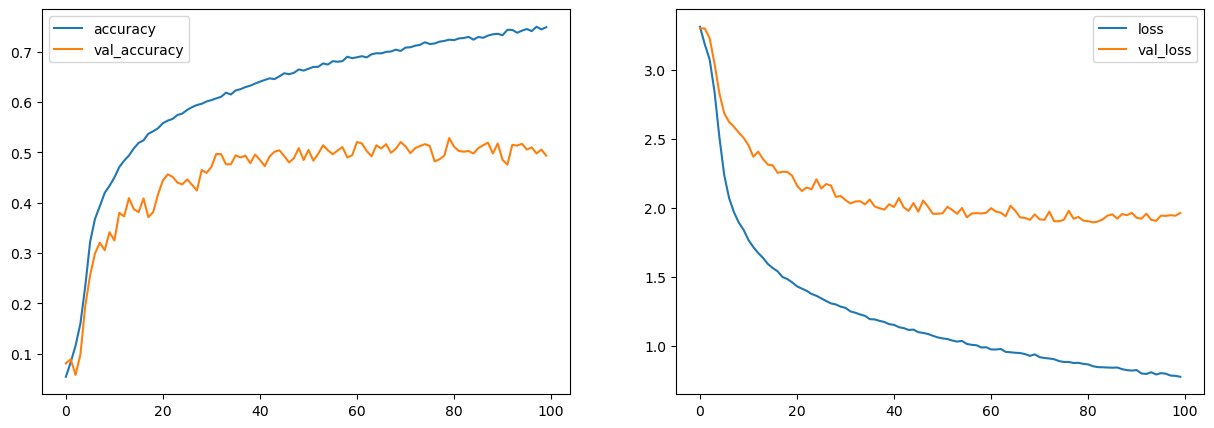

In [6]:
df_hist = model.history.history
df_hist = pd.DataFrame(df_hist)

fig, ax = plt.subplots(1,2, figsize=(15,5))
df_hist[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df_hist[['loss', 'val_loss']].plot(ax=ax[1])